# Train Image Processing using Hugging Face Dataset

Using this deepfashion dataset with different clothes and poses. Just going to test if this is the dataset i really want.
Data Set:
https://huggingface.co/datasets/lirus18/deepfashion

In [2]:
from datasets import load_dataset

# Load the DeepFashion dataset
dataset = load_dataset("lirus18/deepfashion", split="train")

print(dataset)


Generating train split: 100%|██████████| 13679/13679 [00:22<00:00, 608.03 examples/s]


Dataset({
    features: ['image', 'openpose', 'cloth', 'caption'],
    num_rows: 13679
})


In [4]:
print(dataset.features)
sample = dataset[0]
print(sample)

{'image': Image(mode=None, decode=True, id=None), 'openpose': Image(mode=None, decode=True, id=None), 'cloth': Image(mode=None, decode=True, id=None), 'caption': Value(dtype='string', id=None)}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024 at 0x11767E300>, 'openpose': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x1024 at 0x116AECF20>, 'cloth': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024 at 0x117676210>, 'caption': ''}


Processing the Dataset

In [10]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset

In [11]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize

])

In [12]:
def preprocess_sample(sample):
    # Select the 'image' or 'cloth' field
    image = sample['image']  # Or use sample['cloth']
    image = transform(image)
    
    # Example: Assign labels (you might need to define these based on your task)
    label = 0  # Replace with actual label logic
    
    return image, label
print(preprocess_sample(sample))

(tensor([[[1.8550, 1.8550, 1.8550,  ..., 1.8893, 1.8893, 1.8893],
         [1.8550, 1.8550, 1.8550,  ..., 1.8893, 1.8893, 1.8893],
         [1.8550, 1.8550, 1.8550,  ..., 1.8893, 1.8893, 1.8893],
         ...,
         [1.7180, 1.7180, 1.7352,  ..., 1.8722, 1.8722, 1.8722],
         [1.7180, 1.7180, 1.7352,  ..., 1.8722, 1.8722, 1.8893],
         [1.7180, 1.7180, 1.7180,  ..., 1.8722, 1.8722, 1.8722]],

        [[2.0084, 2.0084, 2.0084,  ..., 2.0434, 2.0434, 2.0434],
         [2.0084, 2.0084, 2.0084,  ..., 2.0434, 2.0434, 2.0434],
         [2.0084, 2.0084, 2.0084,  ..., 2.0434, 2.0434, 2.0434],
         ...,
         [1.8333, 1.8333, 1.8508,  ..., 1.9734, 1.9734, 1.9734],
         [1.8333, 1.8333, 1.8508,  ..., 1.9734, 1.9734, 1.9909],
         [1.8333, 1.8333, 1.8333,  ..., 1.9734, 1.9734, 1.9734]],

        [[2.1520, 2.1520, 2.1520,  ..., 2.2217, 2.2217, 2.2217],
         [2.1520, 2.1520, 2.1520,  ..., 2.2217, 2.2217, 2.2217],
         [2.1520, 2.1520, 2.1520,  ..., 2.2217, 2.2217, 2

In [13]:
class DeepFashionDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the sample
        sample = self.dataset[idx]
        
        # Extract image and label
        image = sample['image']  # Main image
        caption = sample['caption']  # Label/description
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Assuming labels are in the 'caption' field, convert to numeric or category
        label = int(caption) if caption.isdigit() else 0  # Example: You can customize this
        return image, label

Prepare Data Loaders

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
from PIL import Image

# Split the dataset (e.g., 80% train, 10% val, 10% test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(DeepFashionDataset(train_dataset, transform=transform), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(DeepFashionDataset(val_dataset, transform=transform), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(DeepFashionDataset(test_dataset, transform=transform), batch_size=batch_size, shuffle=False)


Defining the ResNet Model

Pre trained model ResNet50 is a deep learning model that uses a convolutional neural network (CNN) to perform visual recognition and image classification

Convolution layers: Apply filters to images to detect patterns, edges, and textures 

Residual blocks: Act as shortcuts that allow the model to skip layers, which helps with training and information flow 

Fully connected layers: Map the learned features to the final output classes

In [15]:
import torch.nn as nn
from torchvision import models

# Load ResNet model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for the number of classes in your dataset
num_classes = 10  # Update this with the actual number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/Users/Param/Desktop/Coding/Projects/FashionTrendsProject/Fashion-Trends-Sentiment-Analysis-and-Forecasting/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Param/Desktop/Coding/Projects/FashionTrendsProject/Fashion-Trends-Sentiment-Analysis-and-Forecasting/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/Param/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:

Train the Model

RESNET50 taking too long will use RESNet 18

In [16]:
import torch.optim as optim

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/10, Loss: 0.008139423889087838
Epoch 2/10, Loss: 4.4229061599012034e-08
Epoch 3/10, Loss: 2.358400320323899e-08


KeyboardInterrupt: 

ResNet18

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_classes = 10  # Set this to the number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final FC layer
model = model.to(device)

/Users/Param/Desktop/Coding/Projects/FashionTrendsProject/Fashion-Trends-Sentiment-Analysis-and-Forecasting/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/Param/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.7MB/s]


In [21]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation Step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy}%")



Epoch 1/10, Loss: 8.572518341061818e-09
Validation Loss: 0.0000, Accuracy: 100.0%
Epoch 2/10, Loss: 0.0
Validation Loss: 0.0000, Accuracy: 100.0%
Epoch 3/10, Loss: 0.0
Validation Loss: 0.0000, Accuracy: 100.0%
Epoch 4/10, Loss: 0.0
Validation Loss: 0.0000, Accuracy: 100.0%
Epoch 5/10, Loss: 0.0
Validation Loss: 0.0000, Accuracy: 100.0%
Epoch 6/10, Loss: 0.0
Validation Loss: 0.0000, Accuracy: 100.0%
Epoch 7/10, Loss: 0.0
Validation Loss: 0.0000, Accuracy: 100.0%
Epoch 8/10, Loss: 0.0
Validation Loss: 0.0000, Accuracy: 100.0%
Epoch 9/10, Loss: 0.0
Validation Loss: 0.0000, Accuracy: 100.0%
Epoch 10/10, Loss: 0.0
Validation Loss: 0.0000, Accuracy: 100.0%


Testing the model

In [22]:
model.eval()
test_loss = 0.0

correct = 0

total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.0000, Accuracy: 100.00%


Save Model

In [23]:
torch.save(model.state_dict(), "resnet18_deepfashion.pth")

Test this model to do image processing

In [25]:
import torch
from torchvision import models, transforms
from PIL import Image

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = models.resnet18(pretrained=False)  # Initialize ResNet18
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # Adjust for the number of classes
model.load_state_dict(torch.load("resnet18_deepfashion.pth", map_location=device))
model = model.to(device)
model.eval()  # Set model to evaluation mode


/Users/Param/Desktop/Coding/Projects/FashionTrendsProject/Fashion-Trends-Sentiment-Analysis-and-Forecasting/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/tc/hg976np16n7_h4z6hh2mznb80000gq/T/ipykernel_72840/2827839123.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no l

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension


In [32]:
# Predict category for a new image
def predict_category(image_path, model, categories):
    image = preprocess_image(image_path).to(device)
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)  # Get the index of the highest score
    return categories[predicted.item()]  # Map index to category name

categories = ["T-shirt", "Jacket", "Dress", "Shirt", "Pants", "Shorts", "Skirt", "Coat", "Sweater", "Shoes"]

# Predict
image_path = "try.jpg"
predicted_category = predict_category(image_path, model, categories)
print(f"Predicted Category: {predicted_category}")


Predicted Category: T-shirt


Bad Dataset trying new one

Using this deepfashion dataset with different clothes and poses. Just going to test if this is the dataset i really want.
Data Set:
https://huggingface.co/datasets/ashraq/fashion-product-images-small

In [35]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("ashraq/fashion-product-images-small")

# Inspect dataset structure
print(dataset)

Generating train split: 100%|██████████| 44072/44072 [00:02<00:00, 15751.56 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
        num_rows: 44072
    })
})


In [36]:
print(dataset['train'][0])


{'id': 15970, 'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Shirts', 'baseColour': 'Navy Blue', 'season': 'Fall', 'year': 2011.0, 'usage': 'Casual', 'productDisplayName': 'Turtle Check Men Navy Blue Shirt', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x177A53C50>}


In [37]:
# Extract unique categories for labels
categories = list(set(sample['subCategory'] for sample in dataset['train']))
print(f"Categories: {categories}")

Categories: ['Topwear', 'Flip Flops', 'Water Bottle', 'Bath and Body', 'Shoes', 'Watches', 'Lips', 'Scarves', 'Innerwear', 'Wristbands', 'Skin Care', 'Ties', 'Umbrellas', 'Headwear', 'Loungewear and Nightwear', 'Beauty Accessories', 'Eyewear', 'Mufflers', 'Free Gifts', 'Nails', 'Bottomwear', 'Wallets', 'Saree', 'Dress', 'Cufflinks', 'Home Furnishing', 'Vouchers', 'Jewellery', 'Apparel Set', 'Perfumes', 'Makeup', 'Belts', 'Fragrance', 'Skin', 'Sports Accessories', 'Socks', 'Bags', 'Eyes', 'Shoe Accessories', 'Sandal', 'Gloves', 'Stoles', 'Accessories', 'Hair', 'Sports Equipment']


In [44]:
# Create a mapping
category_mapping = {category: idx for idx, category in enumerate(categories)}
print(f"Category Mapping: {category_mapping}")

# Add numeric labels to the dataset
def add_labels(example):
    example['label'] = category_mapping[example['subCategory']]
    return example

dataset = dataset.map(add_labels)

Category Mapping: {'Topwear': 0, 'Flip Flops': 1, 'Water Bottle': 2, 'Bath and Body': 3, 'Shoes': 4, 'Watches': 5, 'Lips': 6, 'Scarves': 7, 'Innerwear': 8, 'Wristbands': 9, 'Skin Care': 10, 'Ties': 11, 'Umbrellas': 12, 'Headwear': 13, 'Loungewear and Nightwear': 14, 'Beauty Accessories': 15, 'Eyewear': 16, 'Mufflers': 17, 'Free Gifts': 18, 'Nails': 19, 'Bottomwear': 20, 'Wallets': 21, 'Saree': 22, 'Dress': 23, 'Cufflinks': 24, 'Home Furnishing': 25, 'Vouchers': 26, 'Jewellery': 27, 'Apparel Set': 28, 'Perfumes': 29, 'Makeup': 30, 'Belts': 31, 'Fragrance': 32, 'Skin': 33, 'Sports Accessories': 34, 'Socks': 35, 'Bags': 36, 'Eyes': 37, 'Shoe Accessories': 38, 'Sandal': 39, 'Gloves': 40, 'Stoles': 41, 'Accessories': 42, 'Hair': 43, 'Sports Equipment': 44}


Map: 100%|██████████| 44072/44072 [00:04<00:00, 10492.87 examples/s]


In [45]:
# Split the dataset
train_dataset = dataset['train']
val_dataset = dataset['validation'] if 'validation' in dataset else dataset['train'].train_test_split(test_size=0.1)['test']
test_dataset = dataset['test'] if 'test' in dataset else dataset['train'].train_test_split(test_size=0.1)['test']


In [51]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Create a custom PyTorch Dataset
class FashionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['label']
        
        # Convert image to RGB

        image = image.convert("RGB")  # Ensure 3-channel RGB input


        if self.transform:
            image = self.transform(image)

        return image, label

# Wrap the datasets
train_data = FashionDataset(train_dataset, transform=transform)
val_data = FashionDataset(val_dataset, transform=transform)
test_data = FashionDataset(test_dataset, transform=transform)


In [52]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [53]:
# Initialize ResNet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(categories))  # Adjust for the number of classes
model = model.to(device)


In [54]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%")


Epoch 1/10, Loss: 0.3528
Validation Loss: 0.3057, Accuracy: 91.67%
Epoch 2/10, Loss: 0.2026
Validation Loss: 0.2156, Accuracy: 93.51%
Epoch 3/10, Loss: 0.1561
Validation Loss: 0.1258, Accuracy: 96.32%
Epoch 4/10, Loss: 0.1261
Validation Loss: 0.1150, Accuracy: 96.60%
Epoch 5/10, Loss: 0.1005
Validation Loss: 0.0687, Accuracy: 97.71%
Epoch 6/10, Loss: 0.0823
Validation Loss: 0.0524, Accuracy: 98.21%
Epoch 7/10, Loss: 0.0660
Validation Loss: 0.0594, Accuracy: 98.03%
Epoch 8/10, Loss: 0.0572
Validation Loss: 0.0429, Accuracy: 98.53%
Epoch 9/10, Loss: 0.0473
Validation Loss: 0.0288, Accuracy: 99.05%
Epoch 10/10, Loss: 0.0389
Validation Loss: 0.0765, Accuracy: 97.75%


In [55]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {test_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), "resnet18_fashion.pth")


Test Loss: 0.0715, Accuracy: 98.21%


Test an image with your trained model and get the predicted category

In [57]:
# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 45)  # Adjust for the number of categories
model.load_state_dict(torch.load("resnet18_fashion.pth", map_location=device))
model = model.to(device)
model.eval()  # Set to evaluation mode


/var/folders/tc/hg976np16n7_h4z6hh2mznb80000gq/T/ipykernel_72840/948146621.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet18_fas

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [72]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure 3-channel RGB
    image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension

In [73]:
def predict_category(image_path, model, categories):
    # Preprocess the image
    image = preprocess_image(image_path).to(device)
    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)  # Get the class index with highest score
    print(predicted.item())
    # Return the corresponding category
    return categories[predicted.item()]


In [123]:
# Define your categories
categories = ['Topwear', 'Flip Flops', 'Water Bottle', 'Bath and Body', 'Shoes', 'Watches', 'Lips', 'Scarves', 'Innerwear', 'Wristbands', 'Skin Care', 'Ties', 'Umbrellas', 'Headwear', 'Loungewear and Nightwear', 'Beauty Accessories', 'Eyewear', 'Mufflers', 'Free Gifts', 'Nails', 'Bottomwear', 'Wallets', 'Saree', 'Dress', 'Cufflinks', 'Home Furnishing', 'Vouchers', 'Jewellery', 'Apparel Set', 'Perfumes', 'Makeup', 'Belts', 'Fragrance', 'Skin', 'Sports Accessories', 'Socks', 'Bags', 'Eyes', 'Shoe Accessories', 'Sandal', 'Gloves', 'Stoles', 'Accessories', 'Hair', 'Sports Equipment']

# Test the model with a new image
image_path = "image2.jpg"
predicted_category = predict_category(image_path, model, categories)
print(f"Predicted Category: {predicted_category}")


36
Predicted Category: Bags


In [65]:
from collections import Counter


# Count labels in the dataset

label_counts = Counter([sample['subCategory'] for sample in dataset['train']])

print(f"Label Distribution: {label_counts}")

Label Distribution: Counter({'Topwear': 15383, 'Shoes': 7323, 'Bags': 3053, 'Bottomwear': 2685, 'Watches': 2542, 'Innerwear': 1806, 'Jewellery': 1079, 'Eyewear': 1073, 'Fragrance': 1001, 'Sandal': 961, 'Wallets': 925, 'Flip Flops': 913, 'Belts': 811, 'Socks': 698, 'Dress': 478, 'Loungewear and Nightwear': 464, 'Saree': 427, 'Lips': 425, 'Headwear': 293, 'Nails': 278, 'Makeup': 263, 'Ties': 258, 'Accessories': 129, 'Scarves': 118, 'Cufflinks': 108, 'Apparel Set': 106, 'Free Gifts': 104, 'Stoles': 90, 'Skin': 53, 'Skin Care': 49, 'Mufflers': 38, 'Eyes': 34, 'Sports Equipment': 21, 'Gloves': 20, 'Hair': 19, 'Bath and Body': 9, 'Water Bottle': 7, 'Perfumes': 6, 'Umbrellas': 6, 'Shoe Accessories': 4, 'Wristbands': 4, 'Beauty Accessories': 3, 'Sports Accessories': 3, 'Home Furnishing': 1, 'Vouchers': 1})


In [66]:
# Check the labels in the dataset
print(train_dataset[0]['subCategory'])  # This should match the expected category mapping


Topwear


In [76]:
def debug_prediction(image_path, model):
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image)  # Raw outputs (logits)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities

    print(f"Raw Outputs (Logits): {outputs}")
    print(f"Probabilities: {probabilities}")

debug_prediction("image.jpg", model)


Raw Outputs (Logits): tensor([[ -7.6569, -15.1015, -34.9528, -26.0637, -12.3056,  -2.6976, -24.5503,
         -15.3620, -10.3898,  -9.6374, -14.9289, -23.4300, -40.5403, -13.9362,
           1.9456, -42.5046, -19.0805, -18.6516,  -9.7888, -22.5848,  11.3909,
         -15.7210, -20.3899, -17.2617, -23.6020, -13.9106, -27.2936, -13.2298,
           0.6100, -42.1151, -23.3535, -15.1442, -21.4184, -20.4078,  -8.3845,
         -11.6899, -12.2644, -17.6954, -16.4398, -15.5682, -25.1398, -13.7684,
         -18.1761,  -8.3841, -11.9293]])
Probabilities: tensor([[5.3407e-09, 3.1222e-12, 7.4674e-21, 5.4152e-17, 5.1131e-11, 7.6106e-07,
         2.4598e-16, 2.4061e-12, 3.4733e-10, 7.3706e-10, 3.7103e-12, 7.5412e-16,
         2.7959e-23, 1.0012e-11, 7.9055e-05, 3.9216e-24, 5.8397e-14, 8.9677e-14,
         6.3348e-10, 1.7560e-15, 9.9990e-01, 1.6804e-12, 1.5767e-14, 3.6000e-13,
         6.3495e-16, 1.0272e-11, 1.5830e-17, 2.0293e-11, 2.0790e-05, 5.7890e-24,
         8.1409e-16, 2.9916e-12, 5.6370e-15

Trying with confidence to properly get values

In [119]:
import torch.nn.functional as F

def predict_with_confidence(image_path, model, categories):
    # Preprocess the image
    image = preprocess_image(image_path).to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        confidence, predicted = torch.max(probabilities, 1)  # Get max confidence and class index
    
    return categories[predicted.item()], confidence.item()

# Test
categories = ['Topwear', 'Flip Flops', 'Water Bottle', 'Bath and Body', 'Shoes', 'Watches', 'Lips', 'Scarves', 'Innerwear', 'Wristbands', 'Skin Care', 'Ties', 'Umbrellas', 'Headwear', 'Loungewear and Nightwear', 'Beauty Accessories', 'Eyewear', 'Mufflers', 'Free Gifts', 'Nails', 'Bottomwear', 'Wallets', 'Saree', 'Dress', 'Cufflinks', 'Home Furnishing', 'Vouchers', 'Jewellery', 'Apparel Set', 'Perfumes', 'Makeup', 'Belts', 'Fragrance', 'Skin', 'Sports Accessories', 'Socks', 'Bags', 'Eyes', 'Shoe Accessories', 'Sandal', 'Gloves', 'Stoles', 'Accessories', 'Hair', 'Sports Equipment']
image_path = "try.jpg"
predicted_category, confidence = predict_with_confidence(image_path, model, categories)
print(f"Predicted Category: {predicted_category}, Confidence: {confidence:.2f}")

Predicted Category: Burgundy, Confidence: 0.99


Predicted Category: Bags, Confidence: 1.00


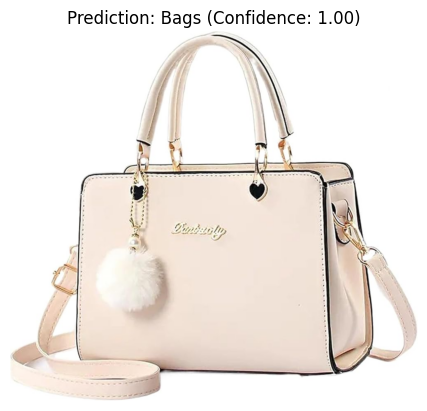

In [122]:
import matplotlib.pyplot as plt

def visualize_prediction(image_path, predicted_category, confidence):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Prediction: {predicted_category} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

image_path = "image2.jpg"
predicted_category, confidence = predict_with_confidence(image_path, model, categories)
print(f"Predicted Category: {predicted_category}, Confidence: {confidence:.2f}")
visualize_prediction(image_path, predicted_category, confidence)


Do object Detection model with using Faster R-CNN from PyTorch using COCO

In [132]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image

# Load pre-trained Faster R-CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(pretrained=True)  # Pre-trained on COCO
model = model.to(device)
model.eval()

/Users/Param/Desktop/Coding/Projects/FashionTrendsProject/Fashion-Trends-Sentiment-Analysis-and-Forecasting/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Param/Desktop/Coding/Projects/FashionTrendsProject/Fashion-Trends-Sentiment-Analysis-and-Forecasting/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [133]:
def preprocess_image_Object(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")

    # Convert to tensor (no resizing to retain object scales)
    image_tensor = F.to_tensor(image)
    return image, image_tensor.unsqueeze(0)  # Add batch dimension

In [143]:
def detect_objects(image_path, model, confidence_threshold=0.5):
    # Preprocess the image
    image, image_tensor = preprocess_image_Object(image_path)
    image_tensor = image_tensor.to(device)

    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract predictions
    predictions = predictions[0]  # Batch index 0
    boxes = predictions['boxes']  # Bounding boxes
    labels = predictions['labels']  # Class labels
    scores = predictions['scores']  # Confidence scores

    # Filter predictions by confidence
    filtered_predictions = [
        (box, label, score) for box, label, score in zip(boxes, labels, scores) if score > confidence_threshold
    ]
    return image, filtered_predictions

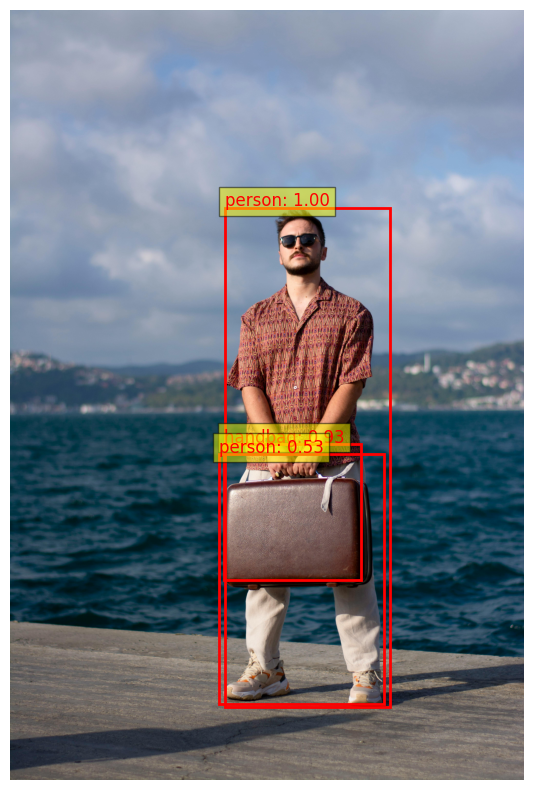

In [144]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define COCO category names
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__',  # 0: background
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


def visualize_detections(image, predictions):
    # Convert to COCO categories if using a pre-trained COCO model
    categories = COCO_INSTANCE_CATEGORY_NAMES
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # Add bounding boxes
    for box, label, score in predictions:
        # Unpack the box
        xmin, ymin, xmax, ymax = box

        # Draw the bounding box
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)

        # Add label and confidence
        ax.text(xmin, ymin - 10, f"{categories[label]}: {score:.2f}", color="red", fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis("off")
    plt.show()

image_path = "mainwithsuit.jpeg"
image, predictions = detect_objects(image_path, model)
visualize_detections(image, predictions)
